<a href="https://colab.research.google.com/github/harmanpreet93/ift6758-data-science/blob/master/Nod2Vec_FIFA17_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Node2Vec showcase

This notebook is about showcasing the qualities of the node2vec algorithm aswell as my implementation of it which can be found and pip installed through [this link](https://github.com/eliorc/node2vec).

Check out the related [Medium post](https://medium.com/@eliorcohen/node2vec-embeddings-for-graph-data-32a866340fef).

Data is taken from https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global

In [0]:
! pip install node2vec

In [0]:
%matplotlib inline

import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')

import sys
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

### Data loading and pre processing

In [0]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    project_path = "/content/drive/My Drive/ML_data/nod2vec_FIFA17/"
else:
    project_path = ""

In [0]:
# Load data 
data = pd.read_csv(project_path + 'FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
...,...,...,...,...
615,marcos_alonso,chelsea,lwb,79
687,gael_clichy,manchester_city,lb,79
850,victor_moses,chelsea,rwb,78
892,willy_caballero,manchester_city,gk,78


Here comes the ugly part.
Since we want to put each team of a graph of nodes and edges, I had to hard-code the relationship between the different FIFA 17 formations.

Also since some formations have the same role (CB for example) in different positions connected to different players, I first use a distinct name for each role which after the learning process I will trim so the positions will be the same.

Finally since position are connected differently in each formation we will add a suffix for the graph presentation and we will trim it also before the Word2vec process

Example:

`'cb'` will become `'cb_1_real_madrid'` because it is the first CB, in Real Madrid's formation, and before running the Word2Vec algorithm it will be trimmed to `cb` again

### Formations

In [0]:
data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
...,...,...,...,...
615,marcos_alonso,chelsea,lwb,79
687,gael_clichy,manchester_city,lb,79
850,victor_moses,chelsea,rwb,78
892,willy_caballero,manchester_city,gk,78


In [0]:
graph_n = nx.Graph()

graph_n = nx.from_pandas_edgelist( 
    data,
    "name",
    "club",
)

In [0]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}


### Creating the graphs for each team

In [0]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    club_data = data[data['club'] == club_name]
    
    club_formation = FORMATIONS[formation]
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}

        
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

In [0]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [0]:
graph = club2graph('real_madrid', '4-3-3_4', graph)

for team, formation in teams:
    graph = club2graph(team, formation, graph)

In [0]:
for e1 in graph_n.edges:
    print(e1)

In [0]:
# importing networkx  
import networkx as nx 
  
# importing matplotlib.pyplot 
import matplotlib.pyplot as plt 

nx.draw(graph_n, with_labels=True)
# nx.draw_circular(graph_n, with_labels=True)

In [0]:
graph.edges

EdgeView([('karim_benzema', 'real_madrid'), ('karim_benzema', 'cam_real_madrid'), ('karim_benzema', 'james_rodriguez'), ('karim_benzema', 'lw_real_madrid'), ('karim_benzema', 'cristiano_ronaldo'), ('karim_benzema', 'rw_real_madrid'), ('karim_benzema', 'gareth_bale'), ('real_madrid', 'gareth_bale'), ('real_madrid', 'cristiano_ronaldo'), ('real_madrid', 'james_rodriguez'), ('real_madrid', 'toni_kroos'), ('real_madrid', 'luka_modric'), ('real_madrid', 'carvajal'), ('real_madrid', 'pepe'), ('real_madrid', 'sergio_ramos'), ('real_madrid', 'marcelo'), ('real_madrid', 'keylor_navas'), ('st_real_madrid', 'cam_real_madrid'), ('st_real_madrid', 'lw_real_madrid'), ('st_real_madrid', 'rw_real_madrid'), ('st_real_madrid', 'gareth_bale'), ('st_real_madrid', 'cristiano_ronaldo'), ('st_real_madrid', 'james_rodriguez'), ('cam_real_madrid', 'cm_1_real_madrid'), ('cam_real_madrid', 'cm_2_real_madrid'), ('cam_real_madrid', 'toni_kroos'), ('cam_real_madrid', 'luka_modric'), ('james_rodriguez', 'cm_1_real_m

### Node2Vec algorithm

In [0]:
node2vec = Node2Vec(graph, dimensions=128, walk_length=8, num_walks=50, workers=4)

Computing transition probabilities: 100%|██████████| 161/161 [00:00<00:00, 2459.42it/s]


In [0]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

In [0]:
model = node2vec.fit(window=10, min_count=1, iter=50)

#### Most similar nodes

In [0]:
model.most_similar("real_madrid")

[('pepe', 0.7784209847450256),
 ('sergio_ramos', 0.7310812473297119),
 ('carvajal', 0.6952682733535767),
 ('toni_kroos', 0.6851989030838013),
 ('keylor_navas', 0.6612115502357483),
 ('gareth_bale', 0.6532031297683716),
 ('luka_modric', 0.6521620750427246),
 ('marcelo', 0.6359331607818604),
 ('james_rodriguez', 0.6253882646560669),
 ('karim_benzema', 0.6125375032424927)]

In [0]:
for node, _ in model.most_similar('cristiano_ronaldo', topn=11):
    # Show only players
    if len(node) > 3:
        print(node)

james_rodriguez
luka_modric
marcelo
karim_benzema
gareth_bale
real_madrid
sergio_ramos
keylor_navas
carvajal
toni_kroos


In [0]:
for node, _ in model.most_similar('gk', topn=10):
    # Show only players
    if len(node) > 3:
        print(node)

thibaut_courtois
willy_caballero
jose_reina
gianluigi_buffon
manuel_neuer
keylor_navas
david_luiz
de_gea


#### Visualization

In [0]:
player_nodes = [x for x in model.wv.vocab if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [0]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [0]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

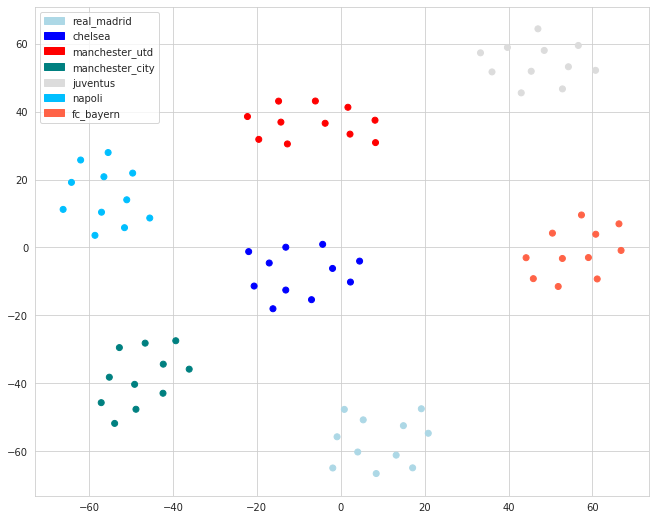

In [0]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);